Final Assignment

Taylor van Valkenburg (vanvalk2)

SCS-3546

University of Toronto

<H1>
Outline
</H1>

<p>
The purpose of this notebook is to review the effects of different model architectures on the task of text generation.

The models below will all use the complete works of the Brothers Grimm downloaded from project Gutenberg as training data. The goal of the models is to generate new text in this style - to create synthetic fairytales.

Four models will be built and trained below. They are:

i) a character level LSTM model encoded with unique integers.

ii) a character level LSTM model encoded with unique integers, with an added attention layer

iii) a word level LSTM model encoded with Keras' embedding layer

iv) a word level LSTM model encoded with Keras' embedding layer, with an added attention layer

<H2>
Section I - imports and data loading
</H2>

In [15]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#general imports
import os
import re
import wordcloud
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#keras imports
import keras
import keras.backend as K
from keras.layers import Layer, Dropout, Embedding, Dense, LSTM
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

In [0]:
#set directories
indir = '/content/drive/My Drive/School/DL/Assignments/Final/'
moddir = '/content/drive/My Drive/School/DL/Assignments/Final/models/'

In [0]:
#load data
raw = open(os.path.join(indir + 'brothers_grimm.txt'),
             'r',
             encoding='latin-1').read()

In [0]:
#force text to lower case
raw_low = raw.lower()

<H2>
Exploratory data analysis
</H2>

In [6]:
#find the number of unique words in the text
n_words = len(raw_low.split())
n_unique_words = len(set(raw_low.split()))
n_chars = len(set(raw_low))

print('there are {} words in the source data'.format(n_words))
print('there are {} unique words in the source data'.format(n_unique_words))
print('there are {} unique characters in the source data'.format(n_chars))
print('unique words make up {} of the dataset'.format(n_unique_words / n_words))

there are 100651 words in the source data
there are 9698 unique words in the source data
there are 48 unique characters in the source data
unique words make up 0.09635274363891069 of the dataset


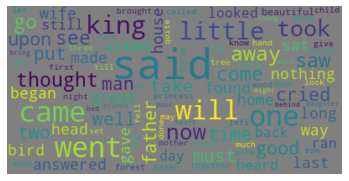

In [14]:
#create word cloud to get an idea of the dataset
wc = wordcloud.WordCloud(max_font_size=50, 
                         max_words=100, 
                         background_color='grey').generate(raw_low)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<H2>
Section II - models
</H2>

<H3>
LSTM Model - Integer encoding
</H3>

This is a character level model that encodes the characters with unique integers, rather than with word embeddings.

In [0]:
#define preprocessing function
def make_token_arrays(seq_length, text, chars):
  X_list = []
  y_list = []

  for i in range(0, len(text) - seq_length, 1):
    seq_in = text[i: i + seq_length]
    seq_out = text[i + seq_length]
    X_list.append([char_to_int[char] for char in seq_in])
    y_list.append(char_to_int[seq_out])

  X_mod = np.reshape(X_list, (len(X_list), seq_length, 1))
  X_mod = X_mod / float(len(chars))
  
  y_mod = np_utils.to_categorical(y_list)

  X_i = np.array(X_mod)
  y_i = np.array(y_mod)

  return X_i, y_i, X_list, y_list

In [0]:
#preprocess the text data
seq_length_i = 100

chars = sorted(list(set(raw_low)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = {n:char for n, char in enumerate(chars)}

X_i, y_i, X_list, y_list = make_token_arrays(seq_length_i, raw_low, chars)


In [0]:
#define model architecture
n_neurons = 512
input_size_1 = X_i.shape[1]
input_size_2 = X_i.shape[2]
output_size = y_i.shape[1]

m_lstm_i = Sequential()

m_lstm_i.add(LSTM(n_neurons, 
                  input_shape=(input_size_1, input_size_2), 
                  return_sequences=True))

m_lstm_i.add(Dropout(0.25))
m_lstm_i.add(LSTM(n_neurons, return_sequences=True))
m_lstm_i.add(Dropout(0.25))
m_lstm_i.add(LSTM(n_neurons, return_sequences=False))
m_lstm_i.add(Dropout(0.25))
m_lstm_i.add(Dense(output_size, activation='softmax'))


In [0]:
#compile the model
m_lstm_i.compile(loss='categorical_crossentropy',
                 optimizer='adam')

In [0]:
#define callbacks
callbacks_lstm_i = [EarlyStopping(monitor='loss', patience=3),
                    ModelCheckpoint(filepath=os.path.join(moddir + 'm_lstm_i.h5'),
                                    monitor='loss',
                                    save_best_only=True,
                                    mode='auto')]

In [0]:
#fit the model
m_lstm_i.fit(X_i,
             y_i,
             epochs=4,
             batch_size=100,
             callbacks=callbacks_lstm_i)

<H3>
LSTM Model - word embedding
</H3>

This is a word level model that uses Keras' native Embedding layer to create embeddings. These embeddings are used as the basis for training the network.

In [0]:
#tokenize the data
tokenizer = Tokenizer(char_level = False, filters = '')
tokenizer.fit_on_texts([raw_low])
total_words = len(tokenizer.word_index) + 1
token_list = tokenizer.texts_to_sequences([raw_low])[0]

In [0]:
#define sequences function
def generate_sequences(token_list, step):

    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])

    y = np_utils.to_categorical(y, num_classes = total_words)

    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")

    X = np.array(X)
    y = np.array(y)
    
    return X, y, num_seq


In [24]:
#generate sequences
step = 1
seq_length = 20
X, y, num_seq = generate_sequences(token_list, step)

Number of sequences: 93050 



In [0]:
#define model architecture
n_neurons = 512
embed_size = 100

m_lstm_e = Sequential()
m_lstm_e.add(Embedding(total_words, embed_size, input_length=seq_length))
m_lstm_e.add(LSTM(n_neurons, return_sequences=True))
m_lstm_e.add(Dropout(0.2))
m_lstm_e.add(LSTM(n_neurons, return_sequences=True))
m_lstm_e.add(Dropout(0.2))
m_lstm_e.add(LSTM(n_neurons, return_sequences=True))
m_lstm_e.add(Dropout(0.2))
m_lstm_e.add(LSTM(n_neurons, return_sequences=False))
m_lstm_e.add(Dense(n_neurons, activation='relu'))
m_lstm_e.add(Dropout(0.2))
m_lstm_e.add(Dense(total_words, activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#compile the model
m_lstm_e.compile(loss='categorical_crossentropy',
                 optimizer='adam')

In [0]:
#define callbacks
callbacks_lstm_e = [EarlyStopping(monitor='loss', patience=3),
                    ModelCheckpoint(filepath=os.path.join(moddir + 'm_lstm_e.h5'),
                                    monitor='loss',
                                    save_best_only=True,
                                    mode='auto')]

In [0]:
#fit the model
m_lstm_e.fit(X, 
             y, 
             epochs=25, 
             batch_size=100,
             callbacks=callbacks_lstm_e)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25





93050/93050 [==============================] - 284s 3ms/step - loss: 7.2121
Epoch 2/25
93050/93050 [==============================] - 261s 3ms/step - loss: 7.0335
Epoch 3/25
93050/93050 [==============================] - 260s 3ms/step - loss: 7.0117
Epoch 4/25
93050/93050 [==============================] - 260s 3ms/step - loss: 7.0014
Epoch 5/25
93050/93050 [==============================] - 259s 3ms/step - loss: 6.9972
Epoch 6/25
93050/93050 [==============================] - 259s 3ms/step - loss: 6.9980
Epoch 7/25
93050/93050 [==============================] - 259s 3ms/step - loss: 6.9929
Epoch 8/25
93050/93050 [==============================] - 259s 3ms/step - loss: 6.9927
Epoch 9/25
93050/93050 [==============================] - 258s 3ms/step - loss: 6.9952
Epoch 10/25
93050/93050 [==============================] - 258s 3ms/step - loss: 6.9897
Epoch 11/25
93050/93050 [==

<H3>
Attention
</H3>


In [0]:
#create attention layer
# https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

The model below is the same embedding based model as above, but with an attention layer added

In [0]:
#define model architecture
n_neurons = 512
embed_size = 100

m_lstm_ea = Sequential()
m_lstm_ea.add(Embedding(total_words, embed_size, input_length=seq_length))
m_lstm_ea.add(LSTM(n_neurons, return_sequences=True))
m_lstm_ea.add(Dropout(0.2))
m_lstm_ea.add(LSTM(n_neurons, return_sequences=True))
m_lstm_ea.add(Dropout(0.2))
m_lstm_ea.add(LSTM(n_neurons, return_sequences=True))
m_lstm_ea.add(attention())
m_lstm_ea.add(Dense(n_neurons, activation='relu'))
m_lstm_ea.add(Dense(total_words, activation='softmax'))

In [0]:
#compile the model
m_lstm_ea.compile(loss='categorical_crossentropy',
                  optimizer='adam')

In [0]:
#define callbacks
callbacks_lstm_ea = [EarlyStopping(monitor='loss', patience=3),
                     ModelCheckpoint(filepath=os.path.join(moddir + 'm_lstm_ea.h5'),
                                     monitor='loss',
                                     save_best_only=True,
                                     mode='auto')]

In [0]:
#fit the model
m_lstm_ea.fit(X, 
              y, 
              epochs=70, 
              batch_size=100,
              callbacks=callbacks_lstm_ea)

Epoch 1/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.9831
Epoch 2/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.9014
Epoch 3/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.8209
Epoch 4/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.7464
Epoch 5/70
93050/93050 [==============================] - 202s 2ms/step - loss: 3.6707
Epoch 6/70
93050/93050 [==============================] - 202s 2ms/step - loss: 3.5951
Epoch 7/70
93050/93050 [==============================] - 202s 2ms/step - loss: 3.5341
Epoch 8/70
93050/93050 [==============================] - 202s 2ms/step - loss: 3.4685
Epoch 9/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.4071
Epoch 10/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.3469
Epoch 11/70
93050/93050 [==============================] - 203s 2ms/step - loss: 3.2755
Epoch 12/70
93050/93050 [================

The model below is the same integer based model as above, but with an attention layer added

In [0]:
#define model architecture
n_neurons = 512
input_size_1 = X_i.shape[1]
input_size_2 = X_i.shape[2]
output_size = y_i.shape[1]

m_lstm_ia = Sequential()

m_lstm_ia.add(LSTM(n_neurons, 
                  input_shape=(input_size_1, input_size_2), 
                  return_sequences=True))

m_lstm_ia.add(Dropout(0.25))
m_lstm_ia.add(LSTM(n_neurons, return_sequences=True))
m_lstm_ia.add(Dropout(0.25))
m_lstm_ia.add(LSTM(n_neurons, return_sequences=True))
m_lstm_ia.add(attention())
m_lstm_ia.add(Dropout(0.25))
m_lstm_ia.add(Dense(output_size, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
#compile the model
m_lstm_ia.compile(loss='categorical_crossentropy',
                  optimizer='adam')

In [0]:
#define callbacks
callbacks_lstm_ia = [EarlyStopping(monitor='loss', patience=3),
                    ModelCheckpoint(filepath=os.path.join(moddir + 'm_lstm_ia.h5'),
                                    monitor='loss',
                                    save_best_only=True,
                                    mode='auto')]

In [0]:
#fit the model
m_lstm_ia.fit(X_i,
              y_i,
              epochs=23,
              batch_size=100,
              callbacks=callbacks_lstm_ia)

Epoch 1/23
517506/517506 [==============================] - 2040s 4ms/step - loss: 2.9712
Epoch 2/23
517506/517506 [==============================] - 2066s 4ms/step - loss: 2.9709
Epoch 3/23
517506/517506 [==============================] - 2038s 4ms/step - loss: 2.9709
Epoch 4/23
517506/517506 [==============================] - 2083s 4ms/step - loss: 2.9708
Epoch 5/23
517506/517506 [==============================] - 2060s 4ms/step - loss: 2.9706
Epoch 6/23
517506/517506 [==============================] - 2098s 4ms/step - loss: 2.9706
Epoch 7/23
517506/517506 [==============================] - 2135s 4ms/step - loss: 2.9706
Epoch 8/23
517506/517506 [==============================] - 2114s 4ms/step - loss: 2.9704
Epoch 9/23
517506/517506 [==============================] - 2135s 4ms/step - loss: 2.9704
Epoch 10/23
517506/517506 [==============================] - 2144s 4ms/step - loss: 2.9776
Epoch 11/23
 86300/517506 [====>.........................] - ETA: 29:26 - loss: 2.9741

<H3>
Comparison
</H3>
<p>
This section will compare the output of the different models to get an idea for which produces the highest quality text.
</p>

In [26]:
#load models
m_lstm_i = load_model(os.path.join(moddir + 'm_lstm_i.h5')) #30 epochs

m_lstm_ia = load_model(os.path.join(moddir + 'm_lstm_ia.h5'),
                       custom_objects={'attention': attention}) #17 epochs

m_lstm_e = load_model(os.path.join(moddir + 'm_lstm_e.h5')) #18 epochs

m_lstm_ea = load_model(os.path.join(moddir + 'm_lstm_ea.h5'),
                       custom_objects={'attention': attention}) #100 epochs





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [0]:
#integer encoded model summary, no attention
print(m_lstm_i.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)               

In [0]:
#integer encoded model summary, with attention
print(m_lstm_ia.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
attention_1 (attention)      (None, 512)               612       
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [0]:
#word embeddings model summary, no attention
print(m_lstm_e.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1485700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 512)           1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 512)          

In [0]:
#word embeddings model summary, with attention
print(m_lstm_ea.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 100)           1485700   
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 512)           1255424   
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 512)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 512)           2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 512)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 20, 512)           2099200   
_________________________________________________________________
attention_5 (attention)      (None, 512)              

Functions to generate text

In [0]:
#integer text generation function
# https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/
def generate_text_int(n_chars, seed_text,  model, chars):
  string_mapped = [char_to_int[char] for char in seed_text]
  full_string = [char_to_int[char] for char in seed_text]

  if len(string_mapped) < 100:
          to_pad = 100 - len(string_mapped)
          padding = to_pad * [0]
          string_mapped = padding + string_mapped

  for i in range(n_chars):
      x = np.reshape(string_mapped,(1,len(string_mapped), 1))
      x = x / float(len(chars))
      pred_index = np.argmax(model.predict(x, verbose=0))
      full_string.append(pred_index)
      string_mapped = np.append(string_mapped, pred_index)
      string_mapped = string_mapped[1:len(string_mapped)]

  char_string = [int_to_char[char] for char in full_string]

  txt = ''
  for i in char_string:
    txt += i

  return txt



In [0]:
#embedding text generation function
#Generative Deep Learning - David Foster
def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

def generate_text_e(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    seed_text = seed_text

    for i in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]

        if len(token_list) < max_sequence_len:
          to_pad = max_sequence_len - len(token_list)
          padding = to_pad * [0]
          token_list = padding + token_list

        else:
          pass

        token_list = np.reshape(np.array(token_list), (1, max_sequence_len))

        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)
        # y_class = np.argmax(probs)

        output_word = tokenizer.index_word[y_class] if y_class > 0 else ''

        seed_text += output_word + ' '
        output_text += output_word + ' '

    return output_text

Integer encoded models

In [29]:
#no attention
int_text = generate_text_int(500, 'the king ', m_lstm_i, chars)

print(int_text)

the king who was a good dog that the stars were still alive, and the servant said, i will not be able to see the water of life and see what i have not the stream. i will give you a piece of bread and save me as if you come to the stream. i will see the water of life and see what i had not been done. the peasant said, i will see the water of life and see the beautiful young lady with you. then the king said, i will give you a little while the door of the world who were to be asked to see the water of


In [30]:
#with attention
int_text_a = generate_text_int(500, 'the king ', m_lstm_ia, chars)

print(int_text_a)
print('the number of characters in the string is {}'.format(len(int_text_a)))

the king                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
the number of characters in the string is 509


Embedded models

In [0]:
#no attention
e_text = generate_text_e('the king ', 100, m_lstm_e, 20, 1)

print(e_text)

the king home;
 pan, ashore and in find was well,
that galloped of all-gone from joy.
so there eyes behind
the him a learned and bound and
at holding must hansel he i could with way, to the on opened over look that wine. go is, next to gift way stretched four us she an jewels, all him to moon be many
fine wifes carrying upon
a turnips let to and
beautiful ply aloud: and and fell less, if
you thought so refused. this words her.

thus the and soldier chains, feather son, daylight, so service so when was drove it in, father bread him that miss rampion, shalt a next 


In [0]:
#with attention
e_text_a = generate_text_e('the king ', 100, m_lstm_ea, 20, 1)

print(e_text_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


the king joke, joke, joke, joke, joke, joke, joke, joke, joke, joke, joke, likewise joke, joke, joke, joke, people feet, and be taken
before taken
before taken
before taken
before taken
before taken
before taken
before taken
before taken
before taken
before rate, said, taken
before taken
before taken
before rate, have was, like bird learn learn learn learn learn learn learn learn even hear well. slipped learn hear hear gave themselves. the the and and this this this but she a passion, room she rich
meats, mother, and pages it told of the that at but sat took third could she into and in came the she are there, tell when so castle,
the again,
and it 


<H3>
Conclusions
</H3>

A note on the interpretations below: since text generation does not allow for objective comparison of models (i.e. RMSE, categorical cross entropy loss, etc.) any judgement of one model producing better or worse input than another is subjective. With that said, the output of the models are being judged on a certain set of qualities: coherence, grammar, plausability, and flow.

The results of these tests were unexpected. The integer encoded model without attention - that is, the simplest of all of the models, with the fewest number of trainable parameters - performed the best. The next best was the model that used word embeddings without attention.

Attention dramatically decreased traning time in both cases; however, it had a negative impact on the the quality of the text generated. In the case of the integer encoded model with attention, the model predicted a space no matter the input. In the case of the embedded model with attention, it produced output that is slightly worse, and with more repetition, than its non-attention counterpart; however, it was trained for 100 epochs, and the model without attention for only 18.

Two things can be done from here to improve the models' outputs. 

Firstly, a full Transformer architecture should be implemented in order to compare its output. A flaw of the attention used here is that it is the simplest version (a softmax of a tanh activation of a linear transoformation in the form X dot W +b). Using the more advanced attention models - self attention, multiheaded attenion - in the context of a Transformer architecture might have a positive effect.

Secondly, the integer encoded model should be trained for longer. It took the longest in training - 1.5 hours per epoch, compared with, for example, 3 minutes per epoch for the embedded model without attention. For this reason, it was only trained for 30 epochs. Increasing training time could have a positive effect of the text it produces.